# **Đồ án môn: Lập trình song song - 19KHMT**

## **Thành viên**:
- Nguyễn Quang Thuận - 19127571
- Nguyễn Duy Khang - 19127172
- Đoàn Ngọc Như Khôi - 19127034

In [1]:
# Đoạn code Python để hiển thị file ảnh pnm ở notebook
# Ví dụ để hiển thị file "img.pnm", ở dòng cuối của code cell
# bạn gõ (không cần dấu ! đằng trước): show_pnm('img.pnm')
# LƯU Ý: bạn phải chạy cell này một lần thì mới gọi được hàm show_pnm
from PIL import Image
import numpy as np
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  print("Image size (width x height): {} x {}".format(w, h))
  return Image.fromarray(pixels)

# Đoạn code Python để hiển thị file chứa ma trận ở notebook
# (một dòng của ma trận ứng với một dòng trong file, 
# các phần tử trên mỗi dòng được cách nhau bởi khoảng trắng) 
# Ví dụ để hiển thị file "pixel_importance.txt", ở dòng cuối của code cell
# bạn gõ: show_matrix('pixel_important.txt')
def show_matrix(matrix_file):
  m = np.loadtxt(matrix_file)
  m = m + m.min()
  m = m / m.max()
  m = m * 255
  m = m.astype(np.uint8)
  return Image.fromarray(m)

## **1. Cài đặt tuần tự**


*   Thiết kế:
  * Mục đích: Thu nhỏ hình ảnh seam carving
  * Đầu vào: hình ảnh có màu RGB

    **Bước 1:** Đọc hình ảnh và chuyển hình ảnh sang màu xám
  *  Thực hiện convolution giữa ảnh grayscale với bộ lọc x-Sobel (1)
$$\begin{bmatrix} 1 & 0 & -1 \\ 2 & 0 & -2 \\ 1 & 0 & -1 \end{bmatrix}$$
  * Thực hiện convolution giữa ảnh grayscale với bộ lọc y-Sobel (2)
$$\begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$$
  * Tính độ quan trọng của một pixel
      * Energy của một pixel = |kết quả (1)| + |kết quả (2)|
      
    **Bước 2:** Tính độ quan trọng của các seam
    * Energy của seam = Energy của pixel hiện tại + Min (Energy của pixel liền kề bên dưới được kết nối)
    * Các pixel liền kề bên dưới ở vị trí: left, mid, right

    **Bước 3:** Tìm seam ít quan trọng nhất trong số các seam
    * Duyệt mảng các seam vừa tìm được ở bước 2 chọn ra seam nhỏ nhât

    **Bước 4:** Xóa seam ít quan trọng nhất và nối lại hình ảnh sau khi đã xóa seam
    * Xóa seam ít quan trọng nhất ta tìm được ở bước 3 và nối lại hình ảnh sau khi đã xóa seam

  * output: hình ảnh đã được xóa 1 seam(height * width - 1)

### **Lưu ý**: nếu xóa n seam thì thực hiện n lần quá trình này


## **Đánh giá**: 

Thực hiện xóa 100 seam của một tấm ảnh (640 x 434)

In [ ]:
!nvcc seamcarving.cu -o seamcarving

In [ ]:
!./seamcarving 540 In.pnm out.pnm

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************
Image size (width x height): 640 x 434

Seam Carving by host: 
Time: 7491.040 ms


Image size (width x height): 640 x 434


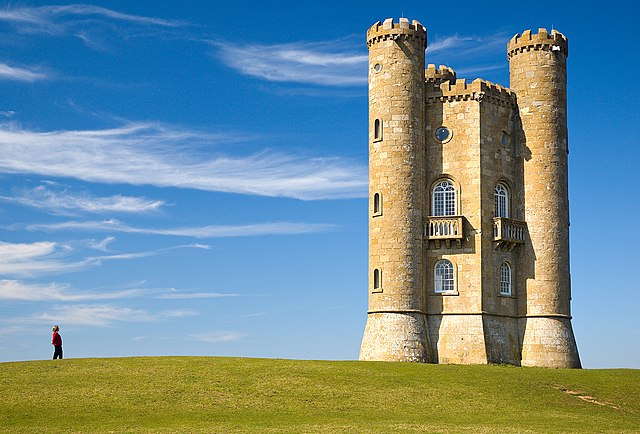

In [ ]:
show_pnm('In.pnm')

Image size (width x height): 540 x 434


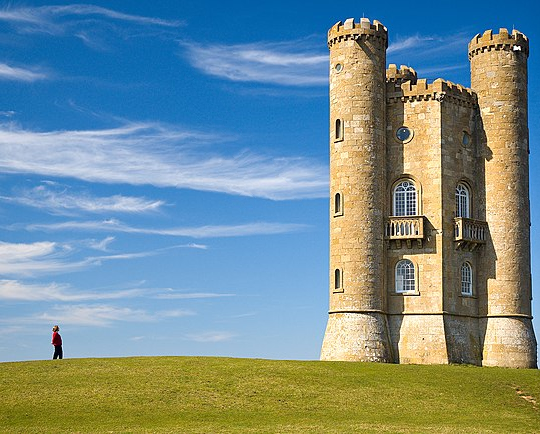

In [ ]:
show_pnm('out_host.pnm')

kết quả chạy ra chính xác nhưng khá chậm

## **2. Cài đặt song song**


*   Thiết kế:
  * Mục đích: Thu nhỏ hình ảnh seam carving
  * Đầu vào: hình ảnh có màu RGB

    **Bước 1:** Đọc hình ảnh và chuyển hình ảnh sang màu xám (thực hiện song song hóa bước này sử dụng bài HW cũ)
  *  Điểm khác biệt là filter lúc này bao gồm cả 2 filter **x-Sobel** và filter **y-Sobel**
  *  Thực hiện convolution giữa ảnh grayscale với bộ lọc x-Sobel (1)
$$\begin{bmatrix} 1 & 0 & -1 \\ 2 & 0 & -2 \\ 1 & 0 & -1 \end{bmatrix}$$
  * Thực hiện convolution giữa ảnh grayscale với bộ lọc y-Sobel (2)
$$\begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$$
  * Tính độ quan trọng của một pixel
      * Energy của một pixel = |kết quả (1)| + |kết quả (2)|
      
    **Bước 2:** Tính độ quan trọng của các seam
    * Thực hiện tính độ quan trọng của các seam tính từ dưới cùng bằng cách chạy vòng lặp với mỗi vòng lặp thì mỗi thread sẽ được phân bố để tính độ quan trọng cho 1 điểm ảnh

    **Bước 3:** Tìm seam ít quan trọng nhất trong số các seam
    * Duyệt mảng các seam vừa tìm được ở bước 2 chọn ra seam nhỏ nhât

    **Bước 4:** Xóa seam ít quan trọng nhất và nối lại hình ảnh sau khi đã xóa seam
    * Mỗi thread sẽ xử lý một điểm ảnh. Dựa vào mảng seam tính được, tính toán vị trí của điểm ảnh hiện tại sẽ trở thành vị trí nào sau khi xóa seam có độ quan trọng ít nhất. Sau đó gán điểm ảnh hiện tại vào vị trí đã được tính toán.

  * output: hình ảnh đã được xóa 1 seam(height * width - 1)


## **Đánh giá**: 

Thực hiện xóa 100 seam của một tấm ảnh (640 x 434)

In [2]:
!nvcc seamcarving_Parallel.cu -o seamcarving_p 

seamcarving_Parallel.cu(341): warning: conversion from a string literal to "char *" is deprecated

seamcarving_Parallel.cu(390): warning: variable "type" was declared but never referenced

seamcarving_Parallel.cu(341): warning: conversion from a string literal to "char *" is deprecated



In [3]:
!./seamcarving_p In.pnm kernel 32 32 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Kernel time: 
344.001007 ms


Image size (width x height): 640 x 434


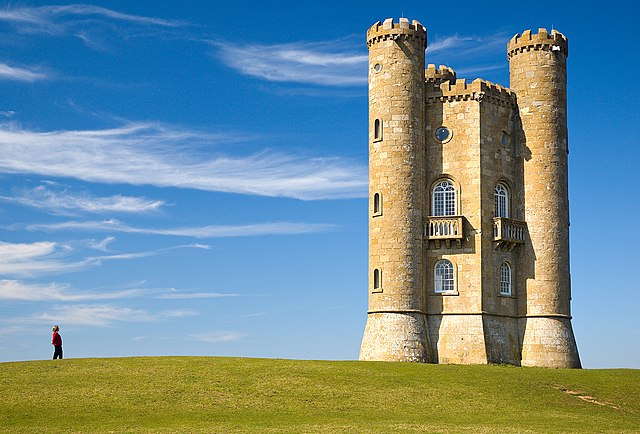

In [4]:
show_pnm('In.pnm')

Image size (width x height): 540 x 434


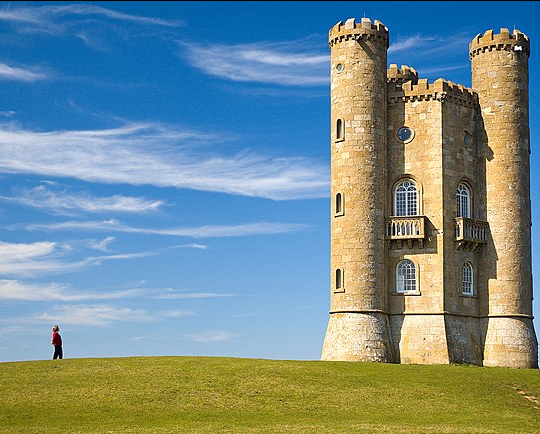

In [6]:
show_pnm('seamcarving_parallel.pnm')

Kết quả cho ra chính xác và chạy nhanh hơn cài đặt tuần tự rất nhiều

## **Khó khăn**
- Thuận: Khó tìm ra thuật toán song song và tối ưu cho phần tuần tự, khó giao tiếp với các thành viên trong nhóm
- Khang: thời gian làm việc ít và các thành viên bị trùng lịch
- Khôi: Bị hạn chế trong giao tiếp và trao đổi bài giữa các thành viên

Tham khảo

- https://vnoi.info/wiki/cs/imageprocessing/Seam-Carving.md
- https://github.com/btxuyenhcmus/seamcarving
- https://github.com/KietAnh/GPU_SeamCarving
- https://stackoverflow.com/